In [12]:
from src import get_soy_condition_features, SEVEN_STATES
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression


In [13]:
df = pd.read_csv("data/processed/waob_features_states.csv")

print(df.describe())

             year  yield_bu_acre      trend  jun_shortfall     temp_JA  \
count   296.00000     296.000000  296.00000     296.000000  296.000000   
mean   2006.00000      44.908917   19.00000       0.288849   73.062411   
std      10.69516       8.491212   10.69516       0.806684    2.952883   
min    1988.00000      24.600000    1.00000       0.000000   62.050000   
25%    1997.00000      39.312421   10.00000       0.000000   71.350000   
50%    2006.00000      44.333371   19.00000       0.000000   73.365759   
75%    2015.00000      50.225000   28.00000       0.000000   75.050000   
max    2024.00000      65.400000   37.00000       3.811081   80.250000   

          prec_JA  prec_JA_sq  dummy_2003  acres_harvested    harvest_ha  
count  296.000000  296.000000  296.000000     2.960000e+02  2.960000e+02  
mean     3.799126   15.570528    0.027027     1.932402e+07  1.354447e+07  
std      1.027341    9.028891    0.162437     1.779968e+07  2.341426e+07  
min      1.045000    1.092025    

count    256.000000
mean      72.990770
std        3.043488
min       62.050000
25%       70.970954
50%       73.300984
75%       75.053341
max       80.250000
Name: temp_JA, dtype: float64


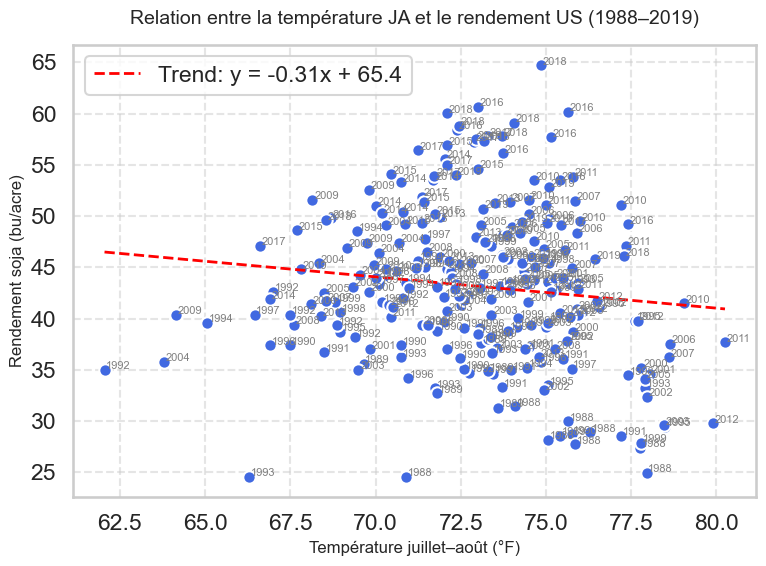

In [14]:
# Garder les années utiles
df = df[(df["year"] >= 1988) & (df["year"] <= 2019)]
print(df["temp_JA"].describe())

# Création du scatter
plt.figure(figsize=(8,6))
plt.scatter(df["temp_JA"], df["yield_bu_acre"], color="royalblue", edgecolor="white", s=80)

# Ajout des labels d'année
for _, row in df.iterrows():
    plt.text(row["temp_JA"] + 0.05, row["yield_bu_acre"] + 0.05, str(int(row["year"])), fontsize=8, color="gray")

# Ajustement de la droite de régression linéaire
coef = np.polyfit(df["temp_JA"], df["yield_bu_acre"], 1)
x_vals = np.linspace(df["temp_JA"].min(), df["temp_JA"].max(), 100)
y_vals = np.polyval(coef, x_vals)
plt.plot(x_vals, y_vals, color="red", linestyle="--", linewidth=2, label=f"Trend: y = {coef[0]:.2f}x + {coef[1]:.1f}")

# Mise en forme
plt.xlabel("Température juillet–août (°F)", fontsize=12)
plt.ylabel("Rendement soja (bu/acre)", fontsize=12)
plt.title("Relation entre la température JA et le rendement US (1988–2019)", fontsize=14, pad=15)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [15]:
# 1) Features conditions
_, annual_crop_condition = get_soy_condition_features(1987, 2024, SEVEN_STATES)

# 2) Charger acreage + yield
df_acreage = pd.read_csv("data/processed/waob_features_states.csv")

# 3) Garder yield + poids
df_y = (df_acreage[["state","year","yield_bu_acre","harvest_ha"]]
        .drop_duplicates(subset=["state","year"]))

# 4) Ajouter yield aux features conditions
cond_y = annual_crop_condition.merge(df_y, on=["state","year"], how="left")

def add_us_weighted_row(df_conditions: pd.DataFrame,
                        weight_col: str = "harvest_ha") -> pd.DataFrame:
    # df_conditions DOIT déjà contenir weight_col (ici via cond_y)
    if weight_col not in df_conditions.columns:
        raise ValueError(f"'{weight_col}' absent de df_conditions (merge yield/poids avant).")

    # colonnes numériques à agréger (exclure poids + year)
    num_cols = df_conditions.select_dtypes(include=[np.number]).columns.tolist()
    num_cols = [c for c in num_cols if c not in [weight_col, "year"]]

    def weighted_mean(g: pd.DataFrame) -> pd.Series:
        w = g[weight_col].fillna(0).astype(float)
        out = {c: (np.average(g[c].astype(float), weights=w) if w.sum() > 0 else np.nan)
               for c in num_cols}
        out[weight_col] = float(w.sum())
        return pd.Series(out)

    # pandas ≥2.2 : include_groups=False pour éviter le warning
    us = (df_conditions.groupby("year", group_keys=False)
                        .apply(weighted_mean, include_groups=False)
                        .reset_index())
    us["state"] = "US"
    return pd.concat([df_conditions, us], ignore_index=True, sort=False)

# 5) Construire df_full avec yield + US
df_full = add_us_weighted_row(cond_y, weight_col="harvest_ha")



In [ ]:
# 6) Filtrer US et supprimer les NaN nécessaires
target = "yield_bu_acre"
features = ["gex_JA_mean","gex_JA_min","gex_week31","gex_trend","fair_JA_mean","pvp_JA_max","cond_index_JA_mean"]

df_us = (df_full[df_full["state"]=="US"]
         .dropna(subset=[target] + features)
         .sort_values("year")
         .copy())

# 7) Plots
sns.set(style="whitegrid", context="talk")
plt.rcParams["figure.figsize"] = (8,6)

# a) Yield vs feature
for feat in features:
    plt.figure()
    sns.scatterplot(x=feat, y=target, data=df_us, s=80)
    X = df_us[[feat]].values
    y = df_us[target].values
    if len(X) > 3 and not np.isnan(X).any():
        model = LinearRegression().fit(X, y)
        xx = np.linspace(X.min(), X.max(), 100).reshape(-1,1)
        plt.plot(xx, model.predict(xx), lw=2, color="red", label="Trend")
    plt.title(f"US Yield vs {feat}")
    plt.xlabel(feat); plt.ylabel("Soybean Yield (bu/ac)")
    plt.legend(); plt.show()

# b) Yield vs écart à la moyenne
for feat in features:
    dev = f"{feat}_dev"
    df_us[dev] = df_us[feat] - df_us[feat].mean()
    plt.figure()
    sns.scatterplot(x=dev, y=target, data=df_us, s=80)
    X = df_us[[dev]].values; y = df_us[target].values
    if len(X) > 3 and not np.isnan(X).any():
        model = LinearRegression().fit(X, y)
        xx = np.linspace(X.min(), X.max(), 100).reshape(-1,1)
        plt.plot(xx, model.predict(xx), lw=2, color="red", label="Trend")
    plt.axvline(0, color="gray", ls="--", lw=1)
    plt.title(f"US Yield vs deviation of {feat} (from mean)")
    plt.xlabel(f"{feat} - mean({feat})"); plt.ylabel("Soybean Yield (bu/ac)")
    plt.legend(); plt.show()


📊 Corrélation simple avec le rendement (US)
                    yield_bu_acre
yield_bu_acre            1.000000
gex_JA_min               0.695586
gex_JA_mean              0.541310
gex_week31               0.519672
cond_index_JA_mean       0.103978
gex_trend               -0.003849
pvp_JA_max              -0.611756
fair_JA_mean            -0.681683


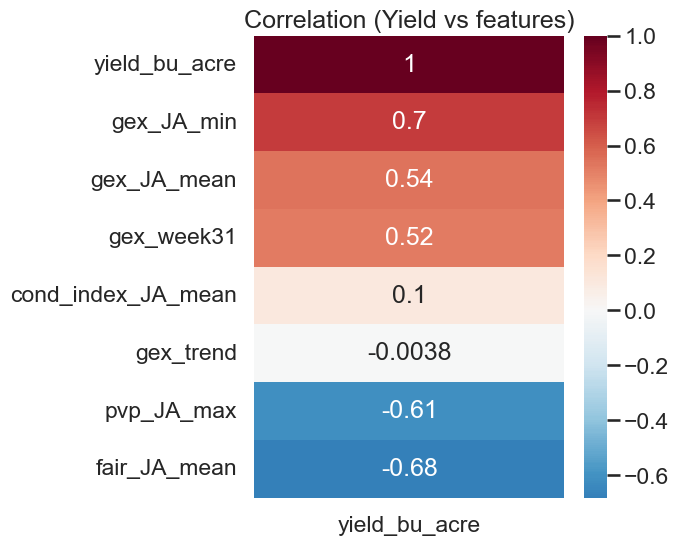

                            OLS Regression Results                            
Dep. Variable:          yield_bu_acre   R-squared:                       0.627
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                     6.974
Date:                Wed, 08 Oct 2025   Prob (F-statistic):           6.68e-05
Time:                        16:07:00   Log-Likelihood:                -109.14
No. Observations:                  37   AIC:                             234.3
Df Residuals:                      29   BIC:                             247.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 45.1080      0

C:\Users\agerard\AppData\Local\Temp\ipykernel_25184\1891179843.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coefs, x="coef_std", y="feature", palette="viridis")


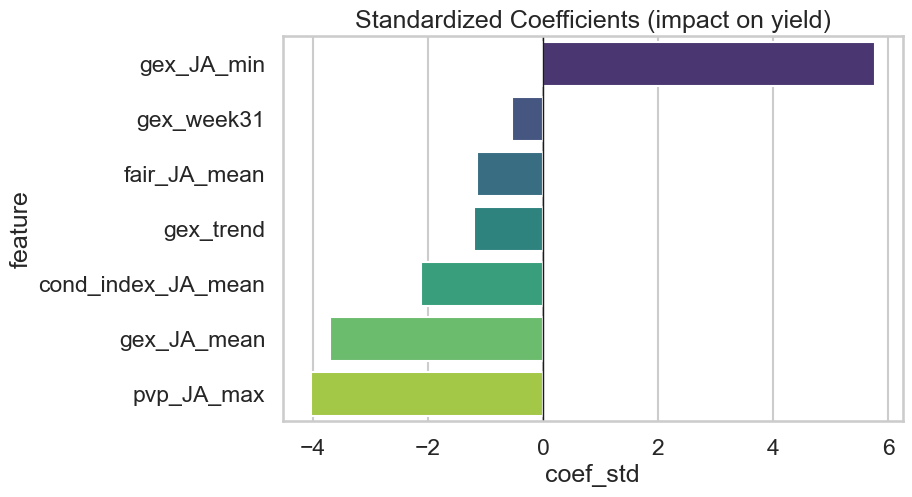


📈 Variance Inflation Factor (multicolinéarité)
               feature          VIF
0         gex_JA_mean  5842.419994
1          gex_JA_min    40.481917
2          gex_week31    24.764685
3           gex_trend     1.698187
4        fair_JA_mean  2761.992922
5          pvp_JA_max    55.170695
6  cond_index_JA_mean  1469.656820


In [17]:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# =============== 1️⃣ Corrélations simples =================
corr = df_us[[target] + features].corr()[[target]].sort_values(by=target, ascending=False)
print("📊 Corrélation simple avec le rendement (US)")
print(corr)

plt.figure(figsize=(5,6))
sns.heatmap(corr, annot=True, cmap="RdBu_r", center=0)
plt.title("Correlation (Yield vs features)")
plt.show()

# =============== 2️⃣ Régression linéaire multiple =================
X = df_us[features].copy()
y = df_us[target].copy()

# Standardiser pour comparer les coefficients
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

X_scaled = sm.add_constant(X_scaled)
model = sm.OLS(y, X_scaled).fit()
print(model.summary())

# =============== 3️⃣ Poids relatifs (coefficients standardisés) =================
coefs = pd.DataFrame({
    "feature": model.params.index[1:],  # ignore intercept
    "coef_std": model.params.values[1:],
    "p_value": model.pvalues.values[1:]
}).sort_values(by="coef_std", ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(data=coefs, x="coef_std", y="feature", palette="viridis")
plt.axvline(0, color="k", lw=1)
plt.title("Standardized Coefficients (impact on yield)")
plt.show()

# =============== 4️⃣ Vérifier multicolinéarité (VIF) =================
vif_df = pd.DataFrame()
vif_df["feature"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X_scaled.values, i+1) for i in range(len(X.columns))]  # +1 car const
print("\n📈 Variance Inflation Factor (multicolinéarité)\n", vif_df)


In [18]:
results = []
for feat in features:
    X = sm.add_constant(df_us[[feat]])
    y = df_us["yield_bu_acre"]
    model = sm.OLS(y, X).fit()
    results.append({
        "feature": feat,
        "coef": model.params[feat],
        "p_value": model.pvalues[feat],
        "r2": model.rsquared
    })
res_df = pd.DataFrame(results).sort_values("r2", ascending=False)
print(res_df)

              feature      coef   p_value        r2
1          gex_JA_min  0.805315  0.000002  0.483840
4        fair_JA_mean -0.833037  0.000003  0.464691
5          pvp_JA_max -0.945765  0.000057  0.374245
0         gex_JA_mean  0.712837  0.000541  0.293017
2          gex_week31  0.599047  0.000980  0.270059
6  cond_index_JA_mean  6.234728  0.540252  0.010812
3           gex_trend -0.002964  0.981961  0.000015


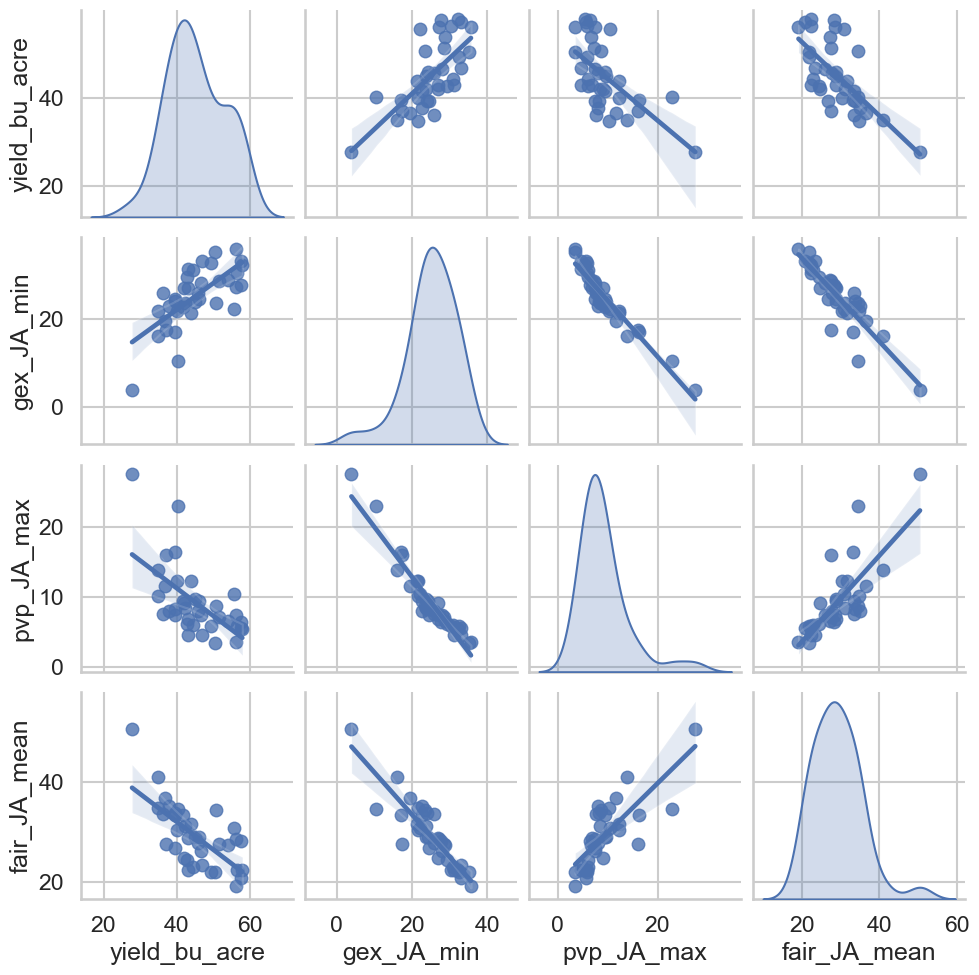

In [19]:
import seaborn as sns, matplotlib.pyplot as plt
sns.pairplot(df_us, vars=["yield_bu_acre","gex_JA_min","pvp_JA_max","fair_JA_mean"], kind="reg", diag_kind="kde")
plt.show()